In [1]:
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777) 

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, validation_size=50000)

# hyper parameters
learning_rate = 0.0001
training_epochs = 1000
batch_size = 100

wait = 0
patient = 10
best_val_cost = 100

class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])

            # img 28x28x1 (black/white), Input Layer
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

            # Convolutional Layer #1
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            bn1 = tf.layers.batch_normalization(inputs=conv1)
            
            # Pooling Layer #1
            pool1 = tf.layers.max_pooling2d(inputs=bn1, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1,
                                         rate=0.3, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            bn2 = tf.layers.batch_normalization(inputs=conv2)
            
            pool2 = tf.layers.max_pooling2d(inputs=bn2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.3, training=self.training)

            # Convolutional Layer #3 and Pooling Layer #3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            bn3 = tf.layers.batch_normalization(inputs=conv3)
            
            pool3 = tf.layers.max_pooling2d(inputs=bn3, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.3, training=self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat,
                                     units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4,
                                         rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=10)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})
    
    def get_cost(self, x_data, y_data, training=False):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})

# initialize
sess = tf.Session()

models = []
num_models = 3
for m in range(num_models):
    models.append(Model(sess, "model" + str(m)))

sess.run(tf.global_variables_initializer())

train_cost_list = []
val_cost_list = []

print('---------------------------------------------')
print('Learning Started!')
print('The number of train set: ' , len(mnist.train.labels))
print('The number of test set: ' , len(mnist.test.labels))
print('The number of validation set: ' , len(mnist.validation.labels))
print('---------------------------------------------')

learning_start_time = datetime.now()

# train my model
for epoch in range(training_epochs):
    epoch_start_time = datetime.now()
    
    avg_train_cost_list = np.zeros(len(models))
    avg_val_cost_list = np.zeros(len(models))
    total_batch = int(mnist.train.num_examples / batch_size)
    
    val_batch_size = int(mnist.validation.num_examples / total_batch)
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        val_xs, val_ys = mnist.validation.next_batch(val_batch_size)
        
        # train each model
        for m_idx, m in enumerate(models):
            c, _ = m.train(batch_xs, batch_ys)
            c_val, _val = m.get_cost(val_xs, val_ys)
            
            avg_train_cost_list[m_idx] += c / total_batch
            avg_val_cost_list[m_idx] += c_val / total_batch
    
    if best_val_cost > sum(avg_val_cost_list)/len(avg_val_cost_list):
        best_val_cost = sum(avg_val_cost_list)/len(avg_val_cost_list)
        wait = 0
    else:
        wait += 1
    
    print('Epoch:', '%04d' % (epoch + 1), '\n|| train cost =', avg_train_cost_list, '\n|| val cost =', avg_val_cost_list, '\n|| wait =', wait)
    print('** The best val cost: ', best_val_cost)
    
    train_cost_list.append(sum(avg_train_cost_list)/len(avg_train_cost_list))
    val_cost_list.append(sum(avg_val_cost_list)/len(avg_val_cost_list))
    
    if patient <= wait:
        break;
    
    epoch_duration = datetime.now() - epoch_start_time
    print('It took ' + str(epoch_duration.seconds) + '.' + str(epoch_duration.microseconds) + ' seconds to this epoch.')
    
    print('---------------------------------------------')
print('Learning Finished!')
learning_duration = datetime.now() - learning_start_time
print('It took ' + str(learning_duration.seconds) + '.' + str(learning_duration.microseconds) + ' seconds to this learning.')

# Test model and check accuracy
test_size = len(mnist.test.labels)
predictions = np.zeros([test_size, 10])
for m_idx, m in enumerate(models):
    print(m_idx, 'Accuracy:', m.get_accuracy(
        mnist.test.images, mnist.test.labels))
    p = m.predict(mnist.test.images)
    predictions += p

ensemble_correct_prediction = tf.equal(
    tf.argmax(predictions, 1), tf.argmax(mnist.test.labels, 1))
ensemble_accuracy = tf.reduce_mean(
    tf.cast(ensemble_correct_prediction, tf.float32))
print('Ensemble accuracy:', sess.run(ensemble_accuracy))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

Epoch: 0017 
|| train cost = [0.07506107 0.0732227  0.07060074] 
|| val cost = [0.04577596 0.04651726 0.04557452] 
|| wait = 0
** The best val cost:  0.045955912514279273
It took 17.814767 seconds to this epoch.
---------------------------------------------
Epoch: 0018 
|| train cost = [0.06796576 0.07356168 0.06685302] 
|| val cost = [0.04376876 0.045211   0.04381104] 
|| wait = 0
** The best val cost:  0.04426359991232554
It took 17.818776 seconds to this epoch.
---------------------------------------------
Epoch: 0019 
|| train cost = [0.0651097  0.06723532 0.06692196] 
|| val cost = [0.04174962 0.04264173 0.04178135] 
|| wait = 0
** The best val cost:  0.042057566360260056
It took 17.787118 seconds to this epoch.
---------------------------------------------
Epoch: 0020 
|| train cost = [0.0630655  0.06460476 0.06447689] 
|| val cost = [0.04043112 0.04054719 0.040831  ] 
|| wait = 0
** The best val cost:  0.04060310181851188
It took 17.815728 seconds to this epoch.
----------------

Epoch: 0044 
|| train cost = [0.0283938  0.03002493 0.0281485 ] 
|| val cost = [0.01749461 0.01728855 0.01799024] 
|| wait = 0
** The best val cost:  0.017591129458354168
It took 17.793790 seconds to this epoch.
---------------------------------------------
Epoch: 0045 
|| train cost = [0.02903495 0.02137576 0.02373116] 
|| val cost = [0.01690406 0.01664118 0.01766727] 
|| wait = 0
** The best val cost:  0.017070835979344945
It took 17.779541 seconds to this epoch.
---------------------------------------------
Epoch: 0046 
|| train cost = [0.02816461 0.02810193 0.02635696] 
|| val cost = [0.01661256 0.01596947 0.0173726 ] 
|| wait = 0
** The best val cost:  0.01665154082312559
It took 17.811428 seconds to this epoch.
---------------------------------------------
Epoch: 0047 
|| train cost = [0.02450274 0.02276524 0.02341687] 
|| val cost = [0.01590275 0.01566478 0.01646097] 
|| wait = 0
** The best val cost:  0.016009500328606614
It took 17.862723 seconds to this epoch.
---------------

Epoch: 0071 
|| train cost = [0.01336828 0.01356635 0.01265699] 
|| val cost = [0.0082689  0.00779658 0.00793938] 
|| wait = 0
** The best val cost:  0.008001620478462429
It took 17.894476 seconds to this epoch.
---------------------------------------------
Epoch: 0072 
|| train cost = [0.01368538 0.01136767 0.01517001] 
|| val cost = [0.00741085 0.00735551 0.00789353] 
|| wait = 0
** The best val cost:  0.007553295313846321
It took 17.883295 seconds to this epoch.
---------------------------------------------
Epoch: 0073 
|| train cost = [0.01190423 0.01439573 0.01329468] 
|| val cost = [0.00688122 0.00733299 0.00773138] 
|| wait = 0
** The best val cost:  0.007315197778322424
It took 17.860628 seconds to this epoch.
---------------------------------------------
Epoch: 0074 
|| train cost = [0.01427352 0.01362791 0.01341999] 
|| val cost = [0.00746939 0.00723387 0.00744206] 
|| wait = 1
** The best val cost:  0.007315197778322424
It took 17.858006 seconds to this epoch.
--------------

Epoch: 0098 
|| train cost = [0.00836126 0.00917968 0.00617992] 
|| val cost = [0.003786   0.00417187 0.00367211] 
|| wait = 1
** The best val cost:  0.003828899620954568
It took 17.891097 seconds to this epoch.
---------------------------------------------
Epoch: 0099 
|| train cost = [0.00815008 0.00681874 0.00704537] 
|| val cost = [0.00337313 0.00381052 0.00388016] 
|| wait = 0
** The best val cost:  0.003687937225137527
It took 17.858652 seconds to this epoch.
---------------------------------------------
Epoch: 0100 
|| train cost = [0.00837514 0.0065688  0.00700611] 
|| val cost = [0.00389388 0.00362064 0.00356447] 
|| wait = 1
** The best val cost:  0.003687937225137527
It took 17.898628 seconds to this epoch.
---------------------------------------------
Epoch: 0101 
|| train cost = [0.00787251 0.00753011 0.00811452] 
|| val cost = [0.00332297 0.00341361 0.00373276] 
|| wait = 0
** The best val cost:  0.003489780413801781
It took 17.844099 seconds to this epoch.
--------------

Epoch: 0125 
|| train cost = [0.00544847 0.00675274 0.00508597] 
|| val cost = [0.00219328 0.00253744 0.00221055] 
|| wait = 2
** The best val cost:  0.002222407308290713
It took 17.809370 seconds to this epoch.
---------------------------------------------
Epoch: 0126 
|| train cost = [0.00558412 0.00651299 0.00607756] 
|| val cost = [0.00208449 0.00244571 0.00225756] 
|| wait = 3
** The best val cost:  0.002222407308290713
It took 17.807180 seconds to this epoch.
---------------------------------------------
Epoch: 0127 
|| train cost = [0.00417417 0.00497816 0.00426347] 
|| val cost = [0.00188762 0.00195491 0.00209283] 
|| wait = 0
** The best val cost:  0.0019784541771029284
It took 17.791183 seconds to this epoch.
---------------------------------------------
Epoch: 0128 
|| train cost = [0.00583605 0.00770251 0.0050193 ] 
|| val cost = [0.0020232  0.00226171 0.00211416] 
|| wait = 1
** The best val cost:  0.0019784541771029284
It took 17.798506 seconds to this epoch.
------------

Epoch: 0152 
|| train cost = [0.00353872 0.00248863 0.00377282] 
|| val cost = [0.00125303 0.00104079 0.00140295] 
|| wait = 0
** The best val cost:  0.0012322553225870556
It took 17.840831 seconds to this epoch.
---------------------------------------------
Epoch: 0153 
|| train cost = [0.00619689 0.00311056 0.00408717] 
|| val cost = [0.00146372 0.00103588 0.00142239] 
|| wait = 1
** The best val cost:  0.0012322553225870556
It took 17.857069 seconds to this epoch.
---------------------------------------------
Epoch: 0154 
|| train cost = [0.00344646 0.00366919 0.00312901] 
|| val cost = [0.00123937 0.0013953  0.00119842] 
|| wait = 2
** The best val cost:  0.0012322553225870556
It took 17.851299 seconds to this epoch.
---------------------------------------------
Epoch: 0155 
|| train cost = [0.00577866 0.00428011 0.00756446] 
|| val cost = [0.00176434 0.00143495 0.00159195] 
|| wait = 3
** The best val cost:  0.0012322553225870556
It took 17.853717 seconds to this epoch.
----------

Epoch: 0179 
|| train cost = [0.00396548 0.00338005 0.00391998] 
|| val cost = [0.00103108 0.00087727 0.00102661] 
|| wait = 0
** The best val cost:  0.0009783195677543213
It took 17.866208 seconds to this epoch.
---------------------------------------------
Epoch: 0180 
|| train cost = [0.0037898  0.0043132  0.00194723] 
|| val cost = [0.00106487 0.00119189 0.00086353] 
|| wait = 1
** The best val cost:  0.0009783195677543213
It took 17.851567 seconds to this epoch.
---------------------------------------------
Epoch: 0181 
|| train cost = [0.00436175 0.00446407 0.00372828] 
|| val cost = [0.00127115 0.00122704 0.00090752] 
|| wait = 2
** The best val cost:  0.0009783195677543213
It took 17.847400 seconds to this epoch.
---------------------------------------------
Epoch: 0182 
|| train cost = [0.00212742 0.00432006 0.00495891] 
|| val cost = [0.0009318  0.00134247 0.00111362] 
|| wait = 3
** The best val cost:  0.0009783195677543213
It took 17.850519 seconds to this epoch.
----------

Epoch: 0206 
|| train cost = [0.00369455 0.00191878 0.00276435] 
|| val cost = [0.00080604 0.00076467 0.00081323] 
|| wait = 2
** The best val cost:  0.0006463603645291491
It took 17.827137 seconds to this epoch.
---------------------------------------------
Epoch: 0207 
|| train cost = [0.00270958 0.00302057 0.00293462] 
|| val cost = [0.00094824 0.00064662 0.00077912] 
|| wait = 3
** The best val cost:  0.0006463603645291491
It took 17.818300 seconds to this epoch.
---------------------------------------------
Epoch: 0208 
|| train cost = [0.00185769 0.00255564 0.00135969] 
|| val cost = [0.00064548 0.00089964 0.00058218] 
|| wait = 4
** The best val cost:  0.0006463603645291491
It took 17.829664 seconds to this epoch.
---------------------------------------------
Epoch: 0209 
|| train cost = [0.00200738 0.00455356 0.00220724] 
|| val cost = [0.0007126  0.00079127 0.00073622] 
|| wait = 5
** The best val cost:  0.0006463603645291491
It took 17.844937 seconds to this epoch.
----------

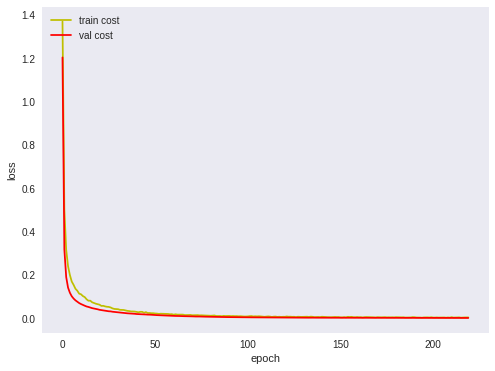

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, cost_ax = plt.subplots(figsize=(8,6))

cost_ax.plot(train_cost_list, 'y', label='train cost')
cost_ax.plot(val_cost_list, 'r', label='val cost')

cost_ax.set_xlabel('epoch')
cost_ax.set_ylabel('loss')

cost_ax.legend(loc='upper left')

cost_ax.grid(False)

plt.show()